<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:balck; font-size:200%; text-align:left;padding: 0px; border-bottom: 3px solid red">Model training</p>

In [1]:
import pandas as pd
import numpy as np
import random
from scipy.stats import pointbiserialr
from  sklearn.preprocessing import OrdinalEncoder
import h5py
import os

# Data Viz

import seaborn as sns
import matplotlib.pyplot as plt

# Image Processing

import cv2
from PIL import Image
from io import BytesIO
import os

# Deep Learning Modules

from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

df = pd.read_csv('./dataset/train-metadata.csv')

path_list = [f"./dataset/train-image/image/{id}.jpg" for id in df.isic_id]

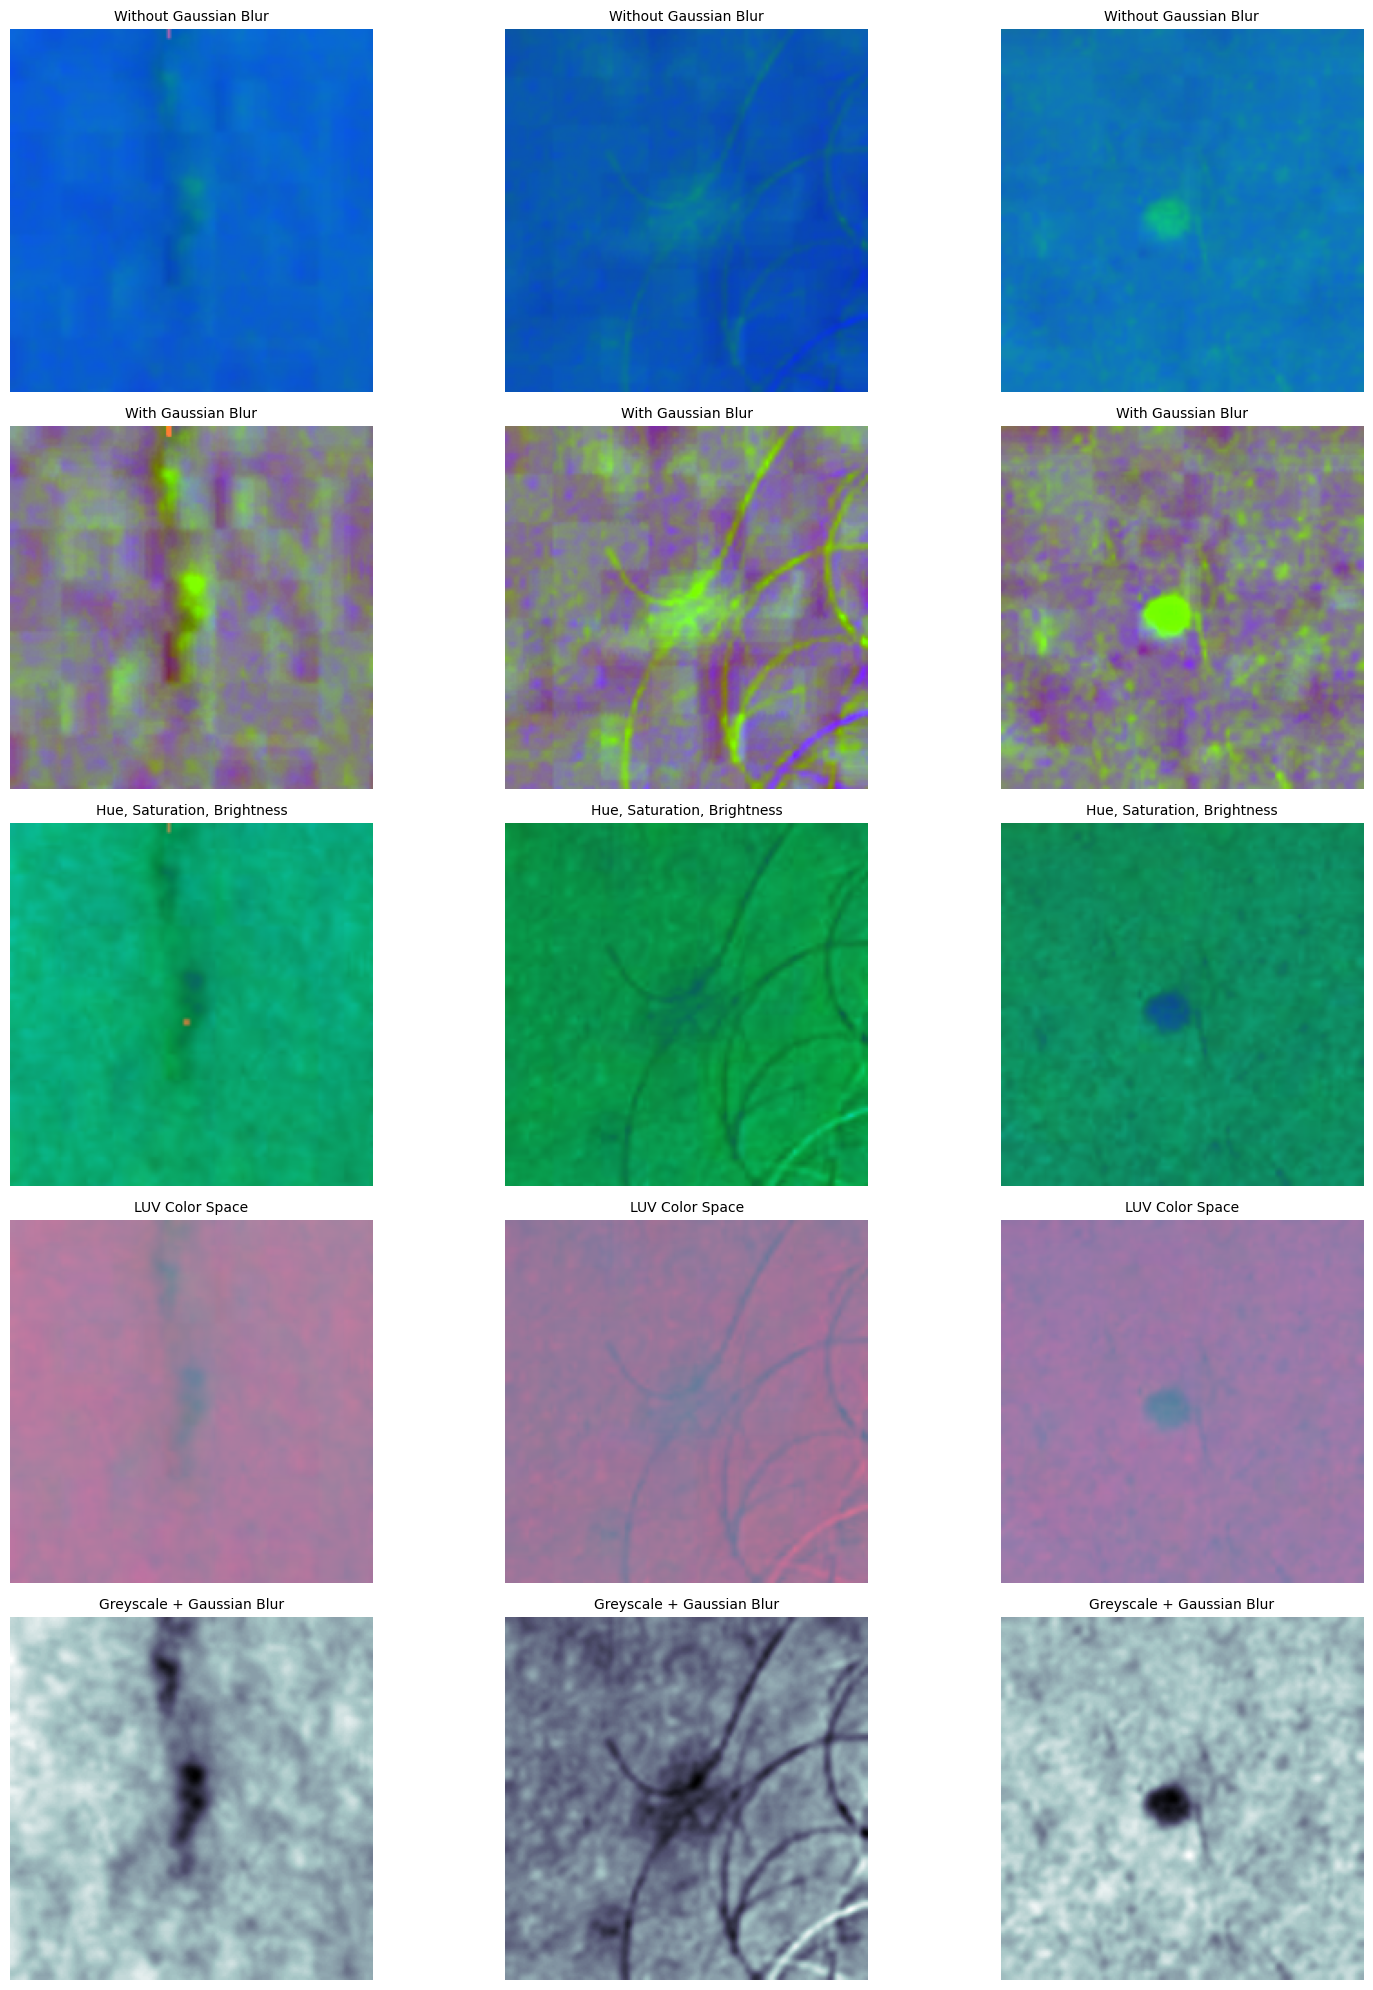

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
import matplotlib.pyplot as plt

def apply_transformations(image_paths):
    selected_images = np.random.choice(image_paths, 3, replace=False)

    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(16, 20))
    methods = ["Without Gaussian Blur", "With Gaussian Blur", "Hue, Saturation, Brightness", "LUV Color Space", "Greyscale + Gaussian Blur"]
    
    for index, method in enumerate(methods):
        for i, path in enumerate(selected_images):
            image = cv2.imread(path)

            if method == "Without Gaussian Blur":
                transformed_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
                transformed_image = cv2.resize(transformed_image, (200, 200))

            elif method == "With Gaussian Blur":
                transformed_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
                transformed_image = cv2.resize(transformed_image, (200, 200))
                transformed_image = cv2.addWeighted(transformed_image, 4, cv2.GaussianBlur(transformed_image, (0, 0), 256/10), -4, 128)

            elif method == "Hue, Saturation, Brightness":
                transformed_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
                transformed_image = cv2.resize(transformed_image, (200, 200))

            elif method == "LUV Color Space":
                transformed_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
                transformed_image = cv2.resize(transformed_image, (200, 200))

            elif method == "Greyscale + Gaussian Blur":
                transformed_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                transformed_image = cv2.resize(transformed_image, (200, 200))
                transformed_image = cv2.GaussianBlur(transformed_image, (5, 5), 0)

            axes[index, i].imshow(transformed_image, cmap=plt.cm.bone if len(transformed_image.shape) == 2 else None)
            axes[index, i].axis('off')
            axes[index, i].set_title(method, fontsize=10)

    plt.tight_layout()
    plt.show()

apply_transformations(path_list)


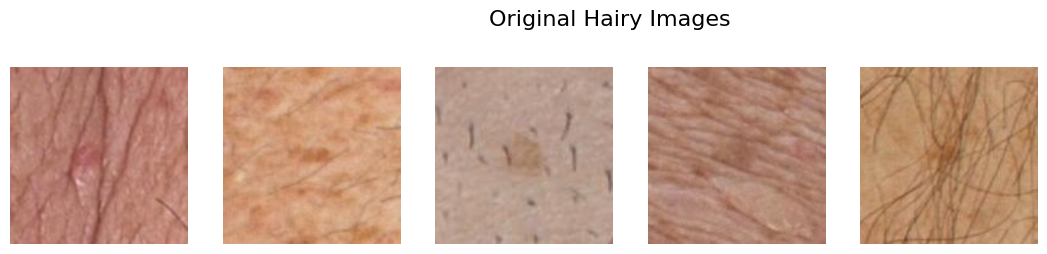

In [4]:
import matplotlib.image as mpimg

image_hair = np.array(path_list)[[1, 2, 8, 11, 13, 17]]

def hair_remove(image):
    # convert image to grayScale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # kernel for morphologyEx
    kernel = cv2.getStructuringElement(1,(17,17))

    # apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)

    # apply thresholding to blackhat
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)

    # inpaint with original image and threshold image
    final_image = cv2.inpaint(image,threshold,1,cv2.INPAINT_TELEA)

    return final_image

# Show the Augmented Images
plt.figure(figsize=(16,3))
plt.suptitle("Original Hairy Images", fontsize = 16)
    
for k, path in enumerate(image_hair[:5]):
    image = mpimg.imread(path)
    image = cv2.resize(image,(300, 300))
        
    plt.subplot(1, 6, k+1)
    plt.imshow(image)
    plt.axis('off')
    


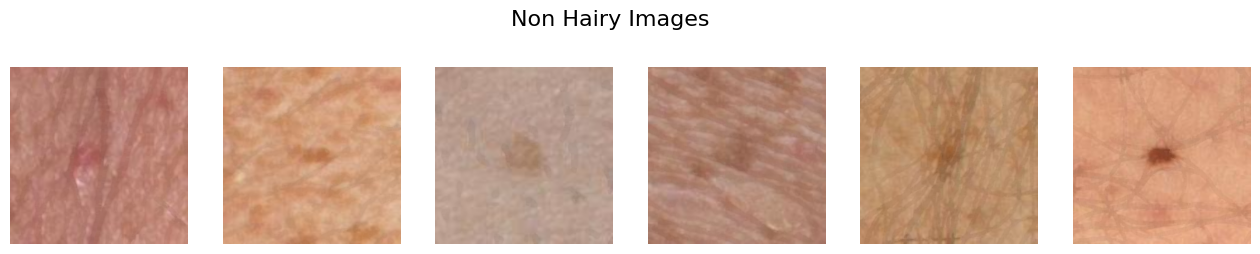

In [5]:
    
# Show the sample
plt.figure(figsize=(16,3))
plt.suptitle("Non Hairy Images", fontsize = 16)
    
for k, path in enumerate(image_hair):
    image = mpimg.imread(path)
    image = cv2.resize(image,(300, 300))
    image = hair_remove(image)
        
    plt.subplot(1, 6, k+1)
    plt.imshow(image)
    plt.axis('off')

In [6]:
def seed_everything(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [7]:
df["path_list"] = pd.Series(path_list)
melanoma = df[df["target"] == 1]
nonmelanoma = df[df["target"] == 0].sample(len(melanoma) * 3)

<Axes: xlabel='target', ylabel='count'>

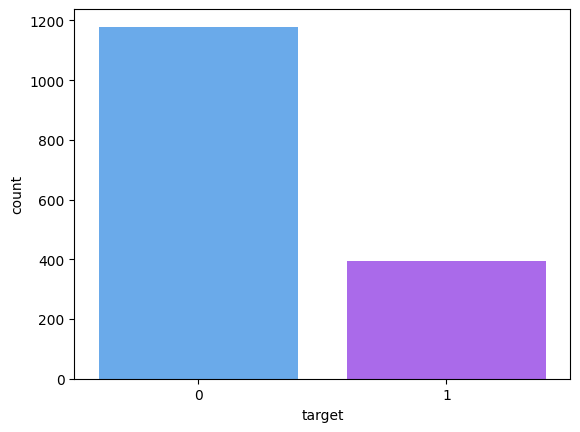

In [8]:
Data = pd.concat([melanoma, nonmelanoma], axis = 0).reset_index(drop = True)
df = Data[["path_list", "target"]]
sns.countplot(x = Data["target"], palette = "cool")

In [9]:



# Incluir la transformación personalizada en el pipeline
transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



    
class FlowerDataset(Dataset):
    
    def __init__(self, df, transform = None, Test_mode = False):
        
        self.df = df.reset_index(drop = True)
        self.path = self.df.iloc[:, 0]
        
        self.test_mode = Test_mode
        if self.test_mode == False:
            self.target = self.df.iloc[:, 1]
        self.transform = transform
        
    def __getitem__(self, index):

        img = Image.open(self.path[index])

        
        if transform is not None:
            
            img = transform(img)
            
        target = self.target[index]
        
        
        if self.test_mode == False:
            
            return img, target
        else:
            return img
       
    
    def __len__(self):
        
        return len(self.path)

In [10]:
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df.iloc[:, 1] = label_encoder.fit_transform(df.iloc[:, 1])

# Mostrar los nombres de las clases y sus correspondientes etiquetas numéricas
for i, class_name in enumerate(label_encoder.classes_):
    print(f"Clase: {class_name}, Etiqueta: {i}")


Train, Test = tts(df, test_size = 0.01/2, stratify = df.iloc[:, 1])
Train, Valid = tts(Train, test_size = 0.1, stratify = Train.iloc[:, 1])

print(f"Train Shape is: {Train.shape}")
print(f"Valid Shape is: {Valid.shape}")
print(f"Test Shape is: {Test.shape}")

print(f"Validation and Test Len is {(Valid.shape[0]  + Test.shape[0]) / df.shape[0] :.2%}")

train_ds = FlowerDataset(Train, transform)
valid_ds = FlowerDataset(Valid, transform_test)
test_ds = FlowerDataset(Test, transform_test)

train_dl = DataLoader(train_ds, batch_size = 32, shuffle = True)
valid_dl = DataLoader(valid_ds, batch_size = 32, shuffle = False)
test_dl = DataLoader(test_ds, batch_size = 32, shuffle = False)

Clase: 0, Etiqueta: 0
Clase: 1, Etiqueta: 1
Train Shape is: (1407, 2)
Valid Shape is: (157, 2)
Test Shape is: (8, 2)
Validation and Test Len is 10.50%


In [11]:
# Training function
def train(model, optimizer, criterion, train_dl, valid_dl, epochs):
    result = []
    val_res = []

    for e in range(epochs):
        print(f"Training the Epoch: {e + 1}")
        model.train()
        total_loss = 0
        total = 0
        correct = 0
        
        for X_train, y_train in train_dl:
            X_train, y_train = X_train.to(device).float(), y_train.to(device).long()
            
            y_pred = model(X_train)
            if isinstance(y_pred, tuple):  # In case of Inception
                y_pred = y_pred[0]
                
            loss = criterion(y_pred, y_train)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            total_loss += loss.item()
            _, predicted = torch.max(y_pred.data, 1)
            total += y_train.size(0)
            correct += (predicted == y_train).sum().item()
            
        acc_train = 100 * correct / total
        _, val_acc = valid(model, valid_dl, device)
        
        print(f'Epoch: [{e+1}/{epochs}], Loss: {total_loss / total:.4f}, Train Acc: {acc_train:.2f}, Val Acc: {val_acc:.2f}')
        result.append(acc_train)
        val_res.append(val_acc)
    
    # Save results to files
    np.savetxt('result.csv', np.array(result), fmt='%.2f', delimiter=',')
    np.savetxt('val_result.csv', np.array(val_res), fmt='%.2f', delimiter=',')  
    
    
    
# Validation Function
def valid(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for sample, target in val_loader:
            sample = sample.to(device).float()
            target = target.to(device).long()
            outputs = model(sample)
            _, predicted = torch.max(outputs.data, 1)
            
            total += target.size(0)
            correct += (predicted == target).sum().item()

    val_accuracy = 100 * correct / total
    return [], val_accuracy

def plot():
    train_data = np.loadtxt('result.csv', delimiter=',')
    val_data = np.loadtxt('val_result.csv', delimiter=',')
    plt.figure()
    plt.plot(range(1, len(train_data) + 1), train_data, color='blue', label='Train')
    plt.plot(range(1, len(val_data) + 1), val_data, color='red', label='Validation')
    plt.legend()
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.title('Train and Validation Accuracy', fontsize=16)
    plt.savefig('plot.png')
    plt.show()

In [12]:
from torchvision import models

In [13]:
Inception = models.inception_v3(pretrained = False)
Resnet50 = models.resnet50(pretrained = True)
Alexnet = models.alexnet(pretrained=True)
VGG = models.vgg19(pretrained = True)
VGG_bn = models.vgg19_bn(pretrained = True)

In [14]:
# Valores de normalización comúnmente utilizados para imágenes RGB en PyTorch
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Función para desnormalizar una imagen
def denormalize(image, mean, std):
    image = image.clone()  # Crear una copia para no modificar el original
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)  # Desnormalizar
    return image

def preds(Model):
    # Ejemplo: obtener un batch de datos
    images, targets = next(iter(test_dl))  
    indices = np.arange(len(images))
    np.random.shuffle(indices)

    fig, axes = plt.subplots(8, 2, figsize=(15, 24))  # 16 filas y 2 columnas (imagen y gráfico de barras)
    axes = axes.ravel()

    # Establecer el color de fondo negro para todos los subplots
    for ax in axes:
        ax.set_facecolor('black')

    # Establecer el color de fondo negro para todo el gráfico
    fig.patch.set_facecolor('black')

    # Invertir el diccionario de LabelEncoder para mapear enteros a etiquetas
    int_to_label = {i: label for i, label in enumerate(label_encoder.classes_)}

    # Cálculo de precisión
    correct_predictions = {label: 0 for label in int_to_label.values()}
    total_predictions = {label: 0 for label in int_to_label.values()}


    # Limitar el número de iteraciones a la cantidad de subplots disponibles
    for i in range(min(len(indices), len(axes) // 2)):
        idx = indices[i]
        image, actual_target = images[idx], targets[idx]
        image_tensor = image.to(device).unsqueeze(0)
        output = Model(image_tensor)
        _, prediction = torch.max(output, 1)

        predicted_label = int_to_label[prediction.cpu().item()]  # Convertir a nombre de clase
        actual_label = int_to_label[actual_target.item()]
        total_predictions[actual_label] += 1
        if predicted_label == actual_label:
            correct_predictions[predicted_label] += 1

        # Convertir el tensor de imagen para graficar
        image = denormalize(image, mean, std)
        image = image.permute(1, 2, 0)  # Cambiar dimensiones de CxHxW a HxWxC
        image = image.cpu().numpy()

        # Mostrar imagen
        axes[2 * i].imshow(image)
        axes[2 * i].set_title(f"Actual Label: {actual_label}", color='white')
        axes[2 * i].axis('off')

        # Mostrar gráfico de barras con probabilidades
        probabilities = torch.nn.functional.softmax(output, dim=1).cpu().detach().numpy().flatten()
        bar_colors = ['white'] * len(probabilities)  # Colores por defecto

        # Cambiar colores de las barras según condiciones
        if predicted_label == actual_label:
            bar_colors[np.argmax(probabilities)] = 'aquamarine'  # Predicción correcta
        else:
            bar_colors[np.argmax(probabilities)] = 'red'  # Predicción incorrecta
            bar_colors[list(int_to_label.values()).index(actual_label)] = 'steelblue'  # Etiqueta correcta

        axes[2 * i + 1].bar(int_to_label.values(), probabilities, color=bar_colors)
        axes[2 * i + 1].set_ylim(0, 1)
        axes[2 * i + 1].set_title(f"Probabilities for {predicted_label}", color='white')

        # Configurar colores de los ejes y anotaciones
        axes[2 * i + 1].tick_params(axis='x', colors='white')
        axes[2 * i + 1].tick_params(axis='y', colors='white')
        axes[2 * i + 1].spines['bottom'].set_color('white')
        axes[2 * i + 1].spines['top'].set_color('white') 
        axes[2 * i + 1].spines['right'].set_color('white')
        axes[2 * i + 1].spines['left'].set_color('white')
        axes[2 * i + 1].yaxis.label.set_color('white')
        axes[2 * i + 1].xaxis.label.set_color('white')

    # Ajustar el diseño y mostrar el gráfico
    plt.tight_layout()
    plt.show()

# **Randomly Select Images check Train and valitation accurecy**

# ResNet50

Training the Epoch: 1
Epoch: [1/20], Loss: 0.4472, Train Acc: 40.00, Val Acc: 75.16
Training the Epoch: 2
Epoch: [2/20], Loss: 0.3334, Train Acc: 60.00, Val Acc: 60.51
Training the Epoch: 3
Epoch: [3/20], Loss: 0.3735, Train Acc: 60.00, Val Acc: 66.24
Training the Epoch: 4
Epoch: [4/20], Loss: 0.3040, Train Acc: 80.00, Val Acc: 47.77
Training the Epoch: 5
Epoch: [5/20], Loss: 0.5276, Train Acc: 70.00, Val Acc: 49.68
Training the Epoch: 6
Epoch: [6/20], Loss: 0.3921, Train Acc: 80.00, Val Acc: 60.51
Training the Epoch: 7
Epoch: [7/20], Loss: 0.3439, Train Acc: 50.00, Val Acc: 47.13
Training the Epoch: 8
Epoch: [8/20], Loss: 1.1156, Train Acc: 40.00, Val Acc: 50.32
Training the Epoch: 9
Epoch: [9/20], Loss: 0.2881, Train Acc: 60.00, Val Acc: 72.61
Training the Epoch: 10
Epoch: [10/20], Loss: 0.1222, Train Acc: 80.00, Val Acc: 29.30
Training the Epoch: 11
Epoch: [11/20], Loss: 0.4231, Train Acc: 70.00, Val Acc: 66.88
Training the Epoch: 12
Epoch: [12/20], Loss: 0.4933, Train Acc: 60.00, V

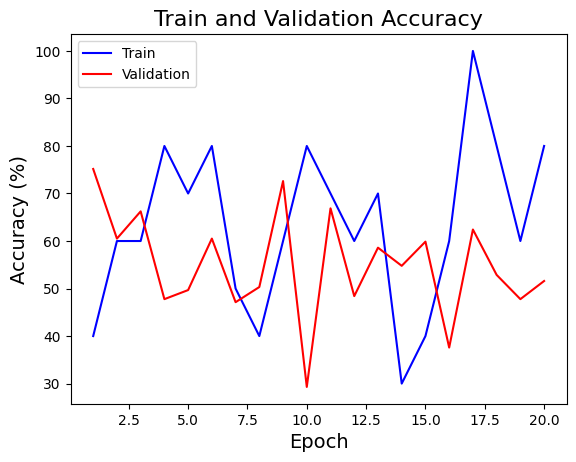

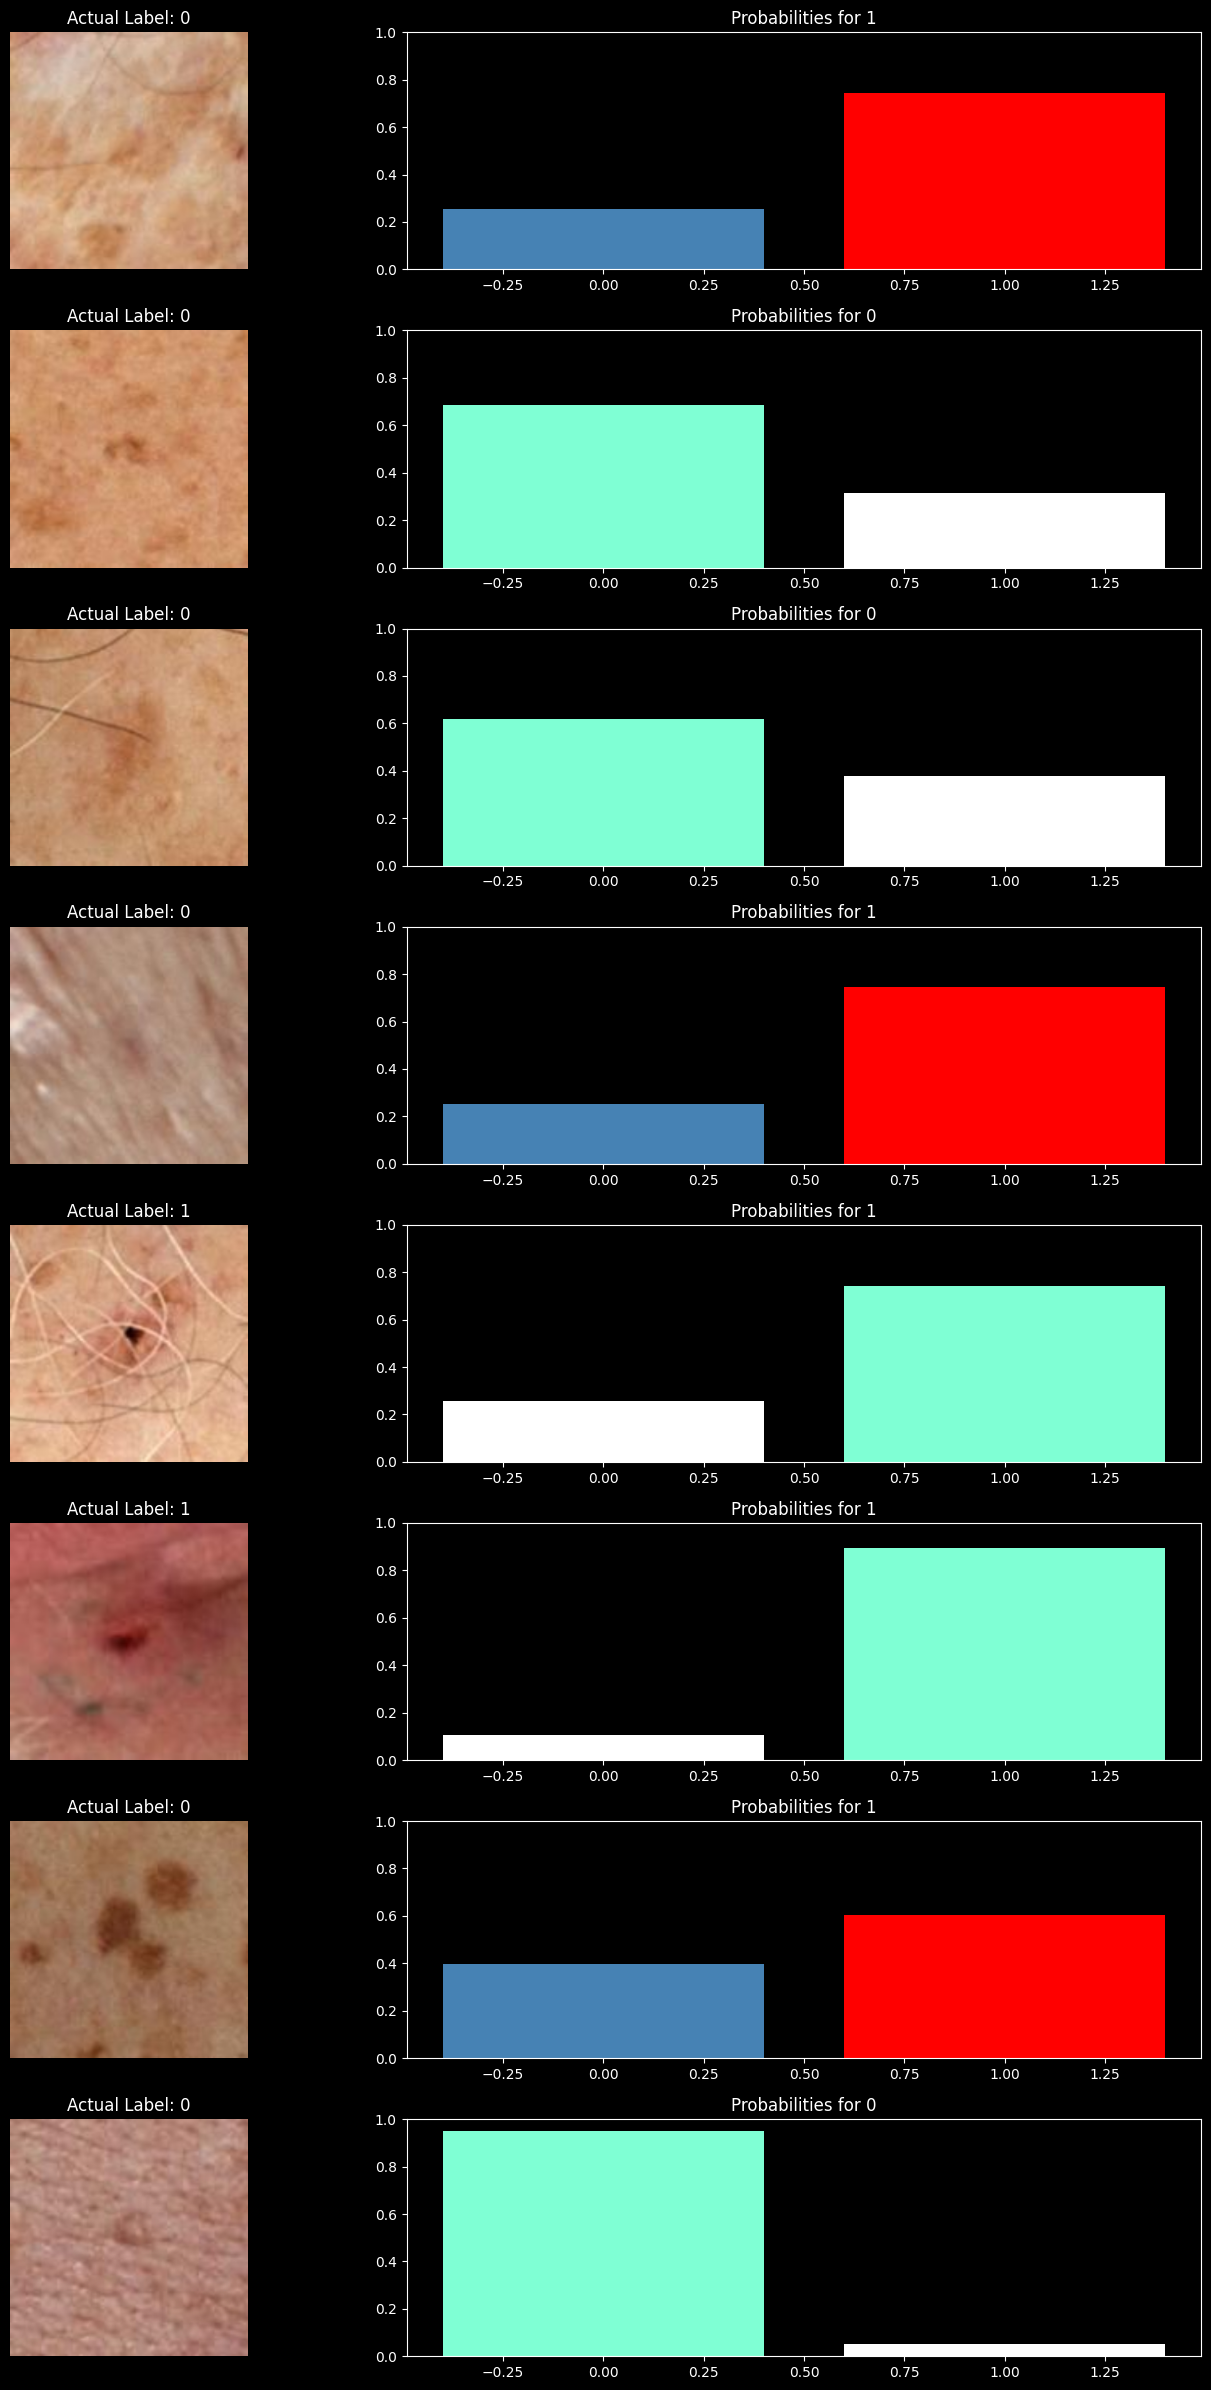

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import random

# Load your ResNet50 model
Resnet50 = models.resnet50(pretrained=True)

# Freeze the layers
for param in Resnet50.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
features = Resnet50.fc.in_features
Resnet50.fc = nn.Linear(features, 2)

# Set the device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Model = Resnet50.to(device)

# Define optimizer and loss function
optimizer = optim.SGD(Model.parameters(), lr=0.003, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Assume 'train_dl' is your training DataLoader
# Get the dataset from the DataLoader
train_dataset = train_dl.dataset

# Randomly select 10 images
indices = random.sample(range(len(train_dataset)), 10)
train_subset = torch.utils.data.Subset(train_dataset, indices)

# Create a new DataLoader with the subset
train_dl_reduced = torch.utils.data.DataLoader(train_subset, batch_size=2, shuffle=True)

# Train the model using the reduced dataset
train(Model, optimizer, criterion, train_dl_reduced, valid_dl, 20)
plot()
preds(Model)


In [18]:
# Save the model
torch.save(Model.state_dict(), r'C:\Users\DELL\Desktop\ISIC Skin Cancer 2024\model\trained_model.h5')

# IncepcttionV3 Use

Training the Epoch: 1
Epoch: [1/20], Loss: 0.2810, Train Acc: 80.00, Val Acc: 75.16
Training the Epoch: 2
Epoch: [2/20], Loss: 0.2184, Train Acc: 90.00, Val Acc: 75.16
Training the Epoch: 3
Epoch: [3/20], Loss: 0.1799, Train Acc: 90.00, Val Acc: 75.16
Training the Epoch: 4
Epoch: [4/20], Loss: 0.1521, Train Acc: 90.00, Val Acc: 75.16
Training the Epoch: 5
Epoch: [5/20], Loss: 0.1791, Train Acc: 90.00, Val Acc: 75.16
Training the Epoch: 6
Epoch: [6/20], Loss: 0.1051, Train Acc: 90.00, Val Acc: 75.16
Training the Epoch: 7
Epoch: [7/20], Loss: 0.1290, Train Acc: 90.00, Val Acc: 75.16
Training the Epoch: 8
Epoch: [8/20], Loss: 0.1058, Train Acc: 100.00, Val Acc: 75.16
Training the Epoch: 9
Epoch: [9/20], Loss: 0.1248, Train Acc: 90.00, Val Acc: 75.16
Training the Epoch: 10
Epoch: [10/20], Loss: 0.1086, Train Acc: 90.00, Val Acc: 75.16
Training the Epoch: 11
Epoch: [11/20], Loss: 0.0365, Train Acc: 100.00, Val Acc: 75.16
Training the Epoch: 12
Epoch: [12/20], Loss: 0.0858, Train Acc: 90.00,

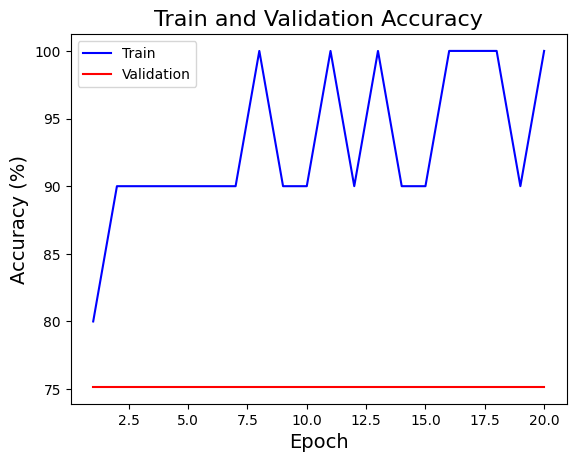

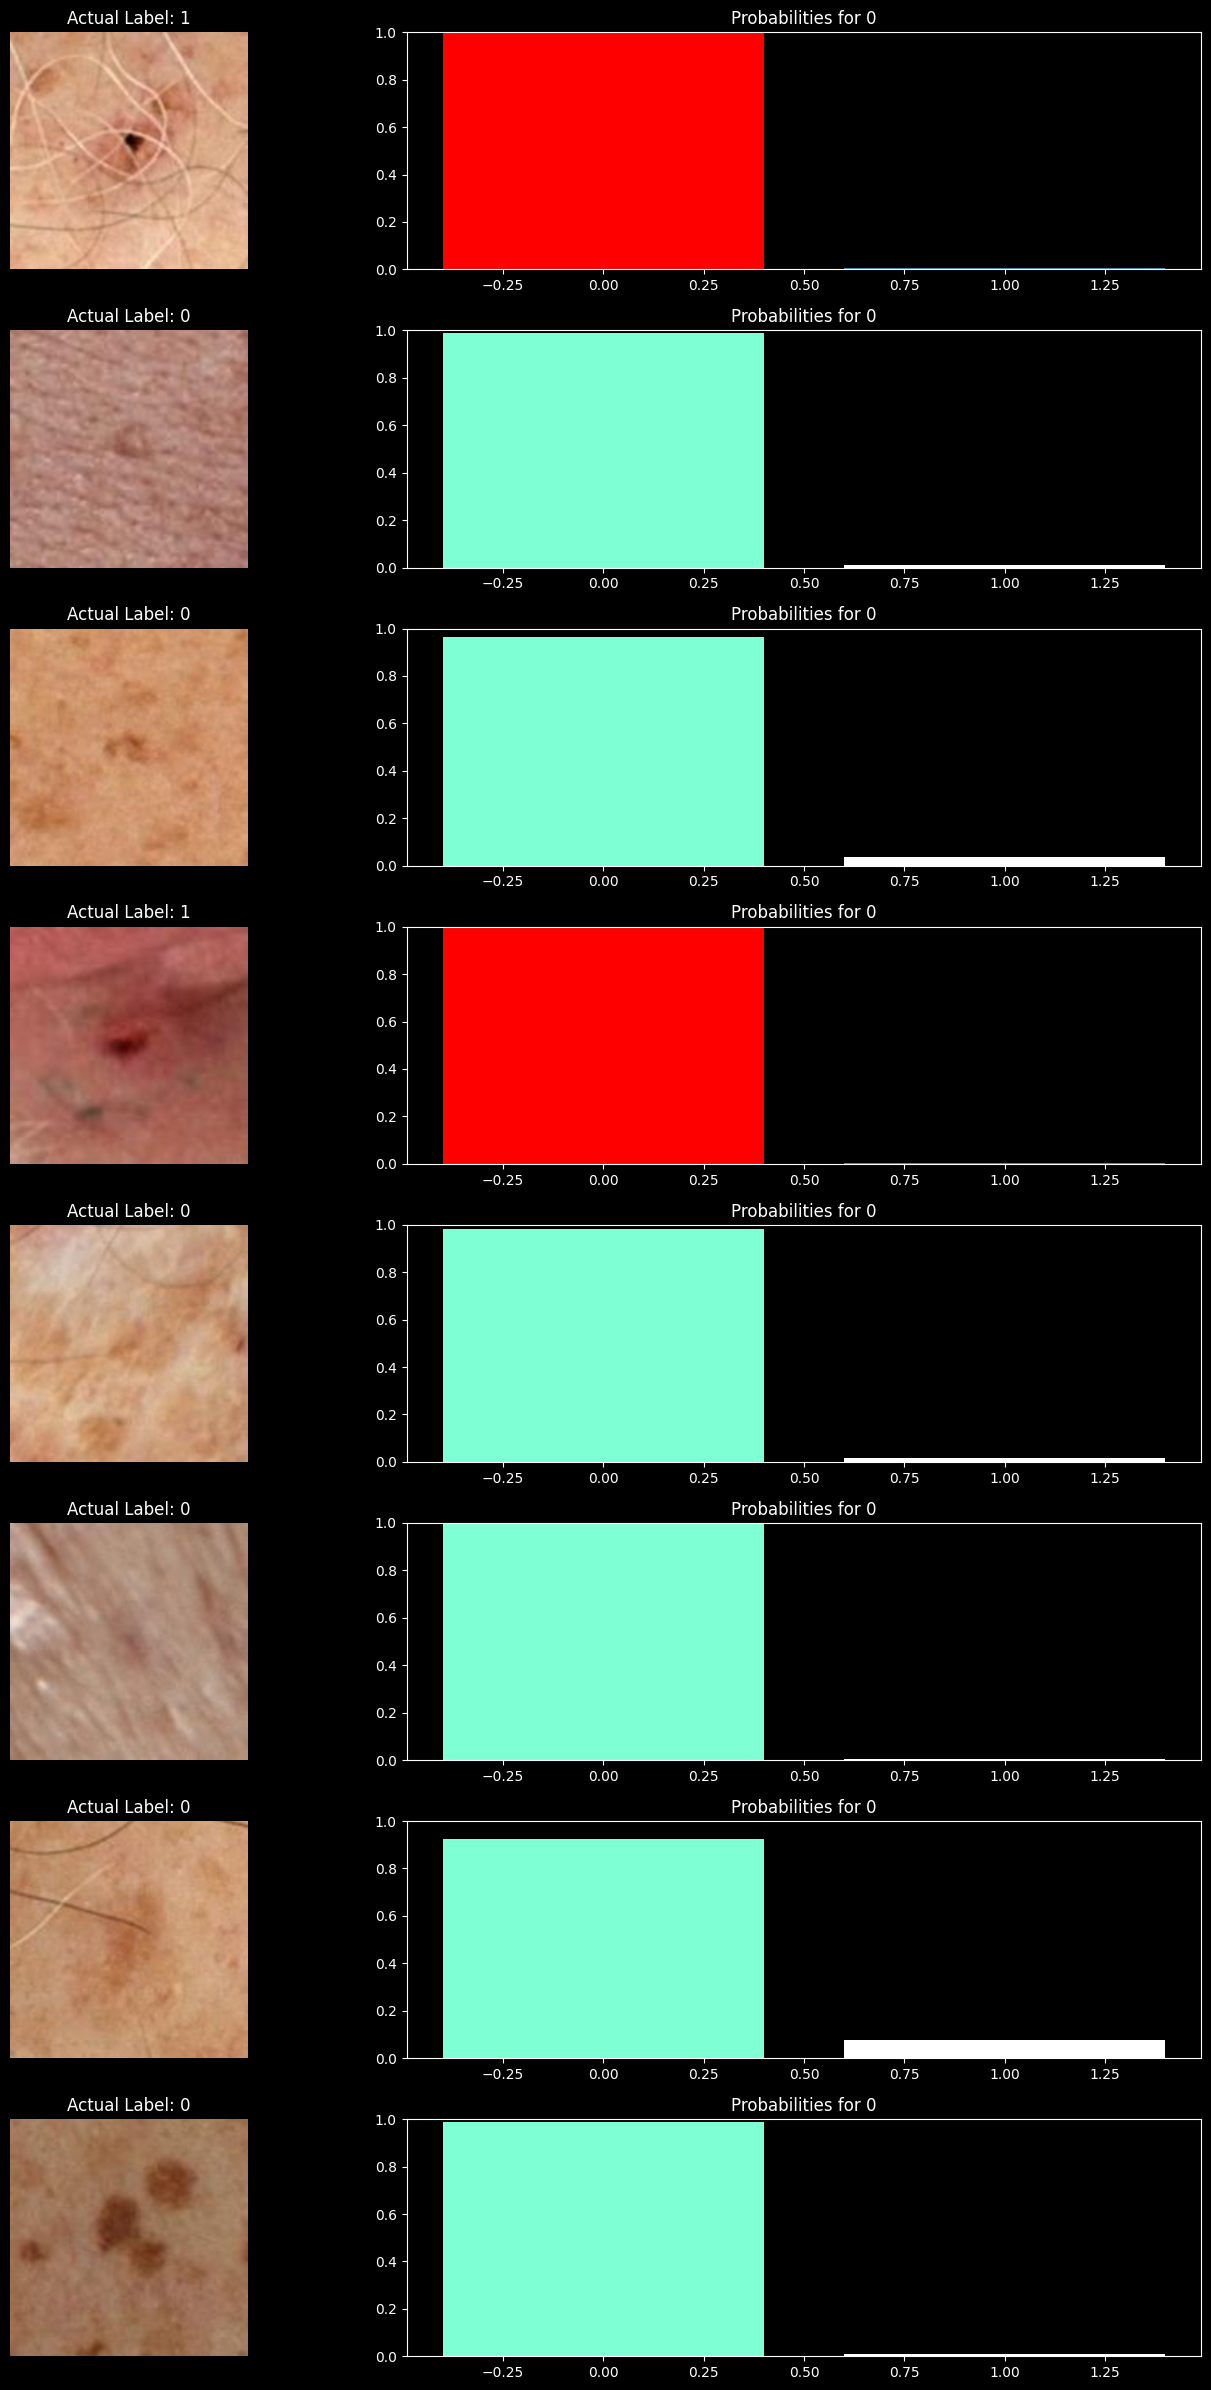

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import random

# Load your ResNet50 model
Inception_v3 = models.inception_v3(pretrained=True)

# Freeze the layers
for param in Inception_v3.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
features = Inception_v3.fc.in_features
Inception_v3.fc = nn.Linear(features, 2)

# Set the device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Model = Inception_v3.to(device)

# Define optimizer and loss function
optimizer = optim.SGD(Model.parameters(), lr=0.003, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Assume 'train_dl' is your training DataLoader
# Get the dataset from the DataLoader
train_dataset = train_dl.dataset

# Randomly select 10 images
indices = random.sample(range(len(train_dataset)), 10)
train_subset = torch.utils.data.Subset(train_dataset, indices)

# Create a new DataLoader with the subset
train_dl_reduced = torch.utils.data.DataLoader(train_subset, batch_size=2, shuffle=True)

# Train the model using the reduced dataset
train(Model, optimizer, criterion, train_dl_reduced, valid_dl, 20)
plot()
preds(Model)


# AlexNet Use

Training the Epoch: 1
Epoch: [1/20], Loss: 0.5767, Train Acc: 60.00, Val Acc: 75.16
Training the Epoch: 2
Epoch: [2/20], Loss: 0.7504, Train Acc: 60.00, Val Acc: 75.16
Training the Epoch: 3
Epoch: [3/20], Loss: 0.3816, Train Acc: 70.00, Val Acc: 54.14
Training the Epoch: 4
Epoch: [4/20], Loss: 0.4323, Train Acc: 80.00, Val Acc: 68.79
Training the Epoch: 5
Epoch: [5/20], Loss: 0.3109, Train Acc: 90.00, Val Acc: 69.43
Training the Epoch: 6
Epoch: [6/20], Loss: 0.3471, Train Acc: 90.00, Val Acc: 42.68
Training the Epoch: 7
Epoch: [7/20], Loss: 0.2217, Train Acc: 80.00, Val Acc: 73.89
Training the Epoch: 8
Epoch: [8/20], Loss: 0.3974, Train Acc: 90.00, Val Acc: 66.24
Training the Epoch: 9
Epoch: [9/20], Loss: 0.4827, Train Acc: 70.00, Val Acc: 39.49
Training the Epoch: 10
Epoch: [10/20], Loss: 0.1405, Train Acc: 90.00, Val Acc: 70.06
Training the Epoch: 11
Epoch: [11/20], Loss: 0.2705, Train Acc: 90.00, Val Acc: 41.40
Training the Epoch: 12
Epoch: [12/20], Loss: 0.3599, Train Acc: 80.00, V

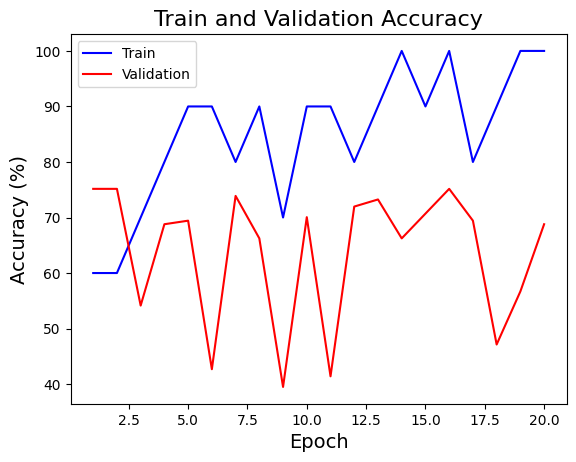

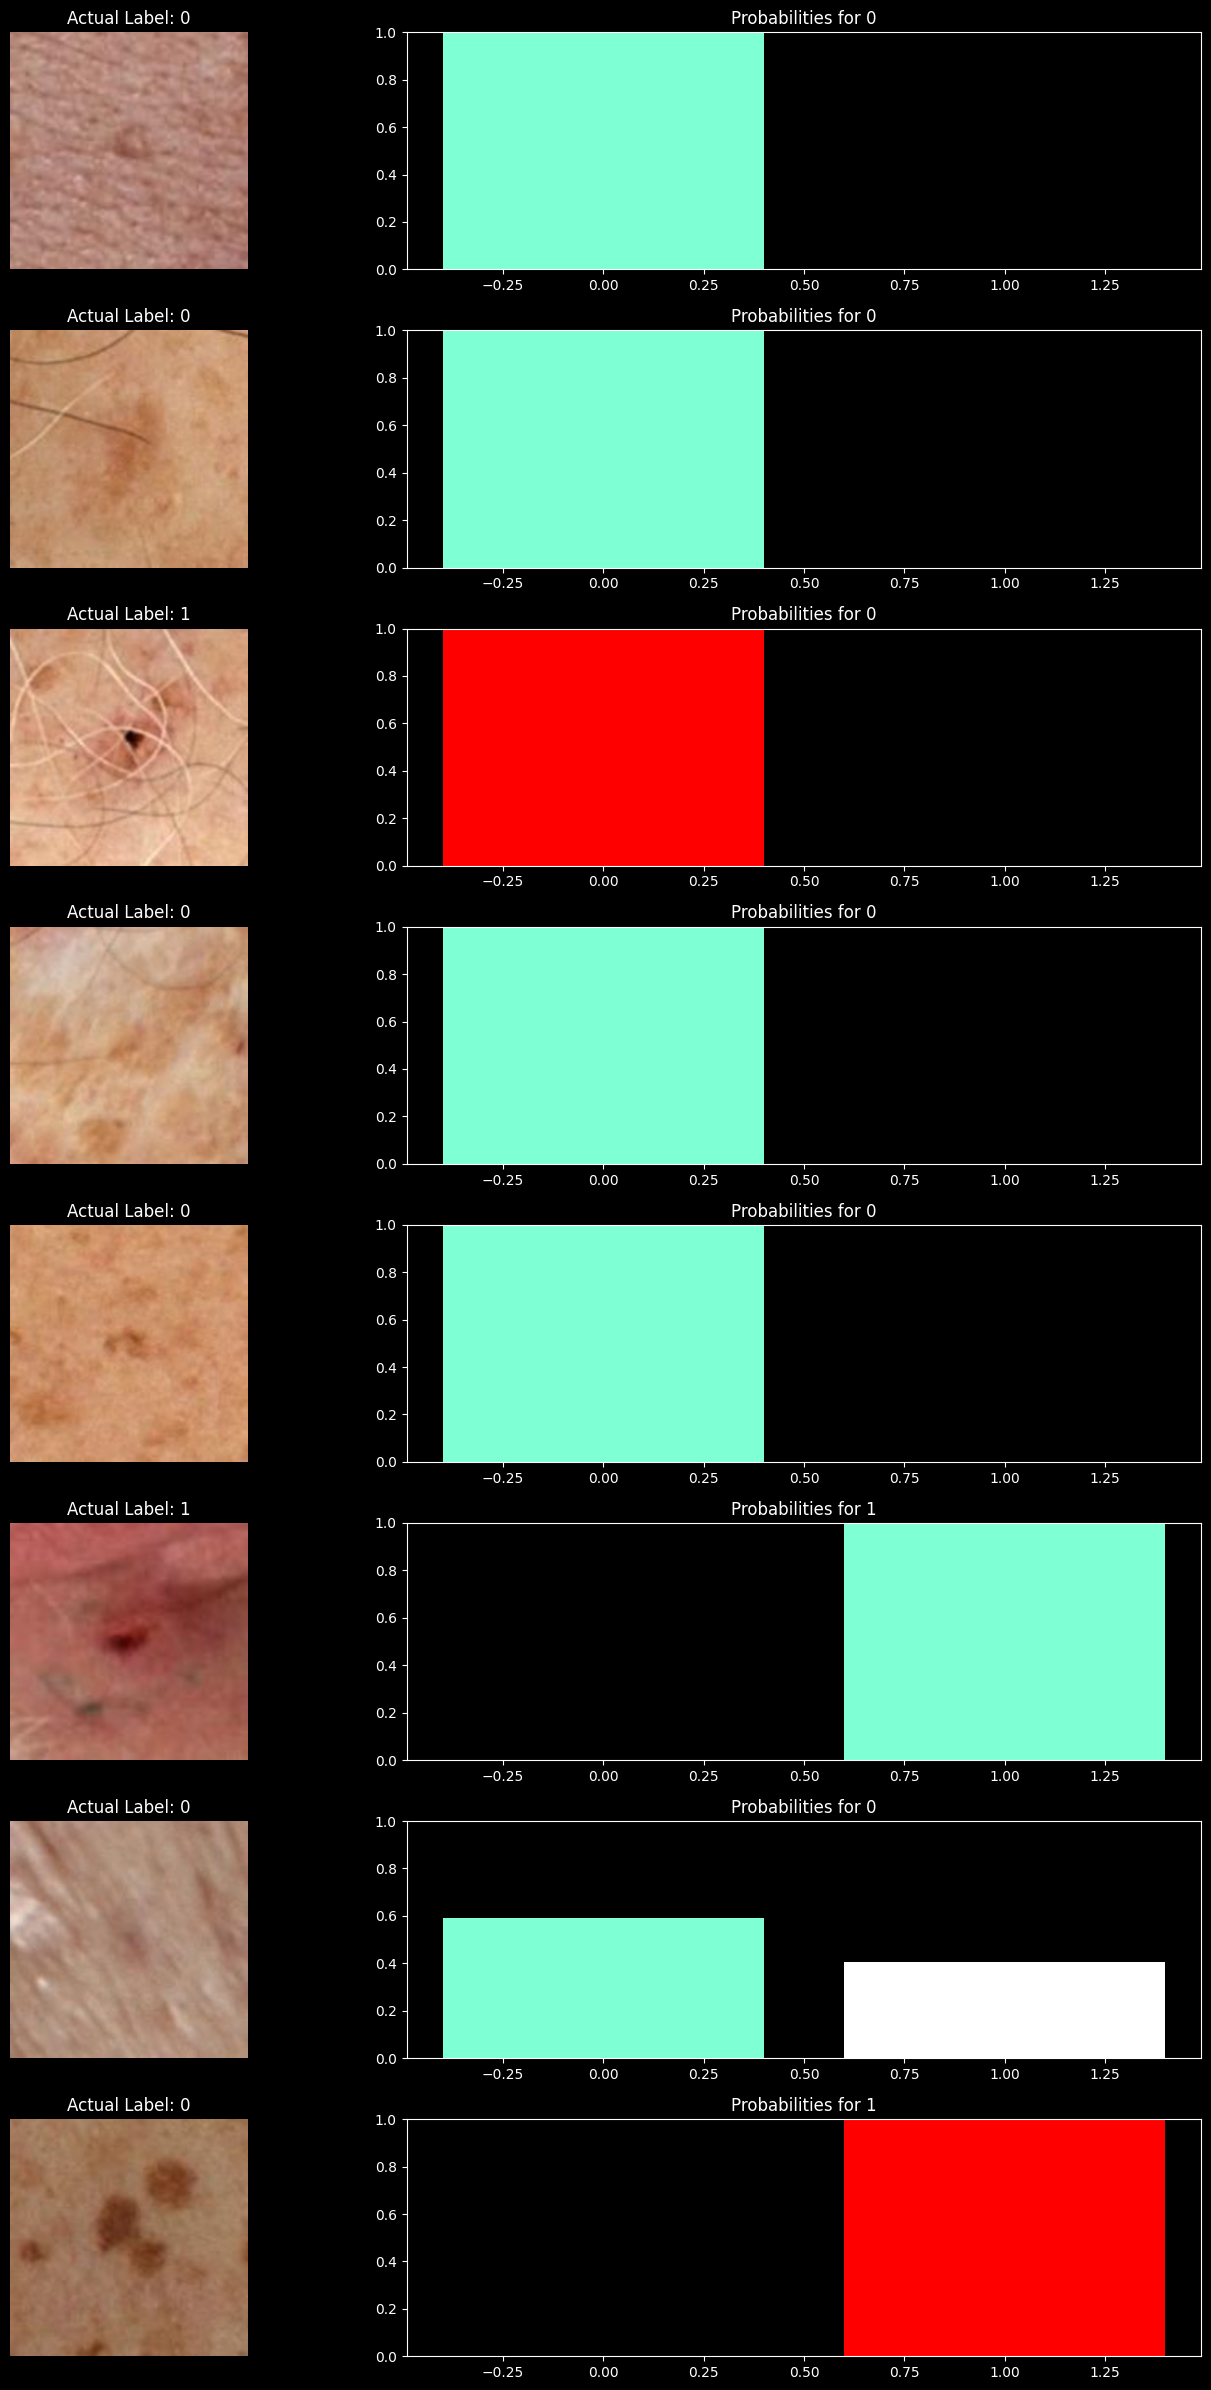

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import random

# Load your AlexNet model
Alexnet = models.alexnet(pretrained=True)

# Freeze the layers
for param in Alexnet.parameters():
    param.requires_grad = False

# Replace the final fully connected layer in the classifier
features = Alexnet.classifier[6].in_features
Alexnet.classifier[6] = nn.Linear(features, 2)

# Set the device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Model = Alexnet.to(device)

# Define optimizer and loss function
optimizer = optim.SGD(Model.parameters(), lr=0.003, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Assume 'train_dl' is your training DataLoader
# Get the dataset from the DataLoader
train_dataset = train_dl.dataset

# Randomly select 10 images
indices = random.sample(range(len(train_dataset)), 10)
train_subset = torch.utils.data.Subset(train_dataset, indices)

# Create a new DataLoader with the subset
train_dl_reduced = torch.utils.data.DataLoader(train_subset, batch_size=2, shuffle=True)

# Train the model using the reduced dataset
train(Model, optimizer, criterion, train_dl_reduced, valid_dl, 20)

# Plot the training/validation loss or accuracy
plot()

# Make predictions with the trained model
preds(Model)


# VGG19

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\DELL/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [05:11<00:00, 1.78MB/s] 


Training the Epoch: 1
Epoch: [1/20], Loss: 0.2620, Train Acc: 70.00, Val Acc: 75.16
Training the Epoch: 2
Epoch: [2/20], Loss: 0.2785, Train Acc: 90.00, Val Acc: 75.16
Training the Epoch: 3
Epoch: [3/20], Loss: 0.1213, Train Acc: 90.00, Val Acc: 75.16
Training the Epoch: 4
Epoch: [4/20], Loss: 0.1810, Train Acc: 80.00, Val Acc: 66.24
Training the Epoch: 5
Epoch: [5/20], Loss: 0.0518, Train Acc: 100.00, Val Acc: 73.89
Training the Epoch: 6
Epoch: [6/20], Loss: 0.0191, Train Acc: 100.00, Val Acc: 74.52
Training the Epoch: 7
Epoch: [7/20], Loss: 0.0068, Train Acc: 100.00, Val Acc: 74.52
Training the Epoch: 8
Epoch: [8/20], Loss: 0.0500, Train Acc: 90.00, Val Acc: 74.52
Training the Epoch: 9
Epoch: [9/20], Loss: 0.0236, Train Acc: 100.00, Val Acc: 73.25
Training the Epoch: 10
Epoch: [10/20], Loss: 0.0099, Train Acc: 100.00, Val Acc: 69.43
Training the Epoch: 11
Epoch: [11/20], Loss: 0.0157, Train Acc: 100.00, Val Acc: 70.06
Training the Epoch: 12
Epoch: [12/20], Loss: 0.0120, Train Acc: 10

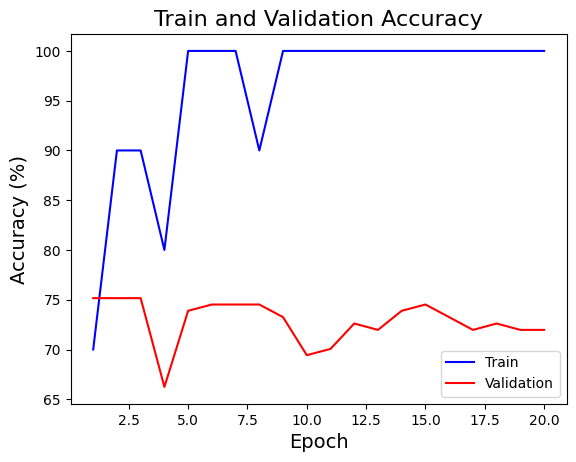

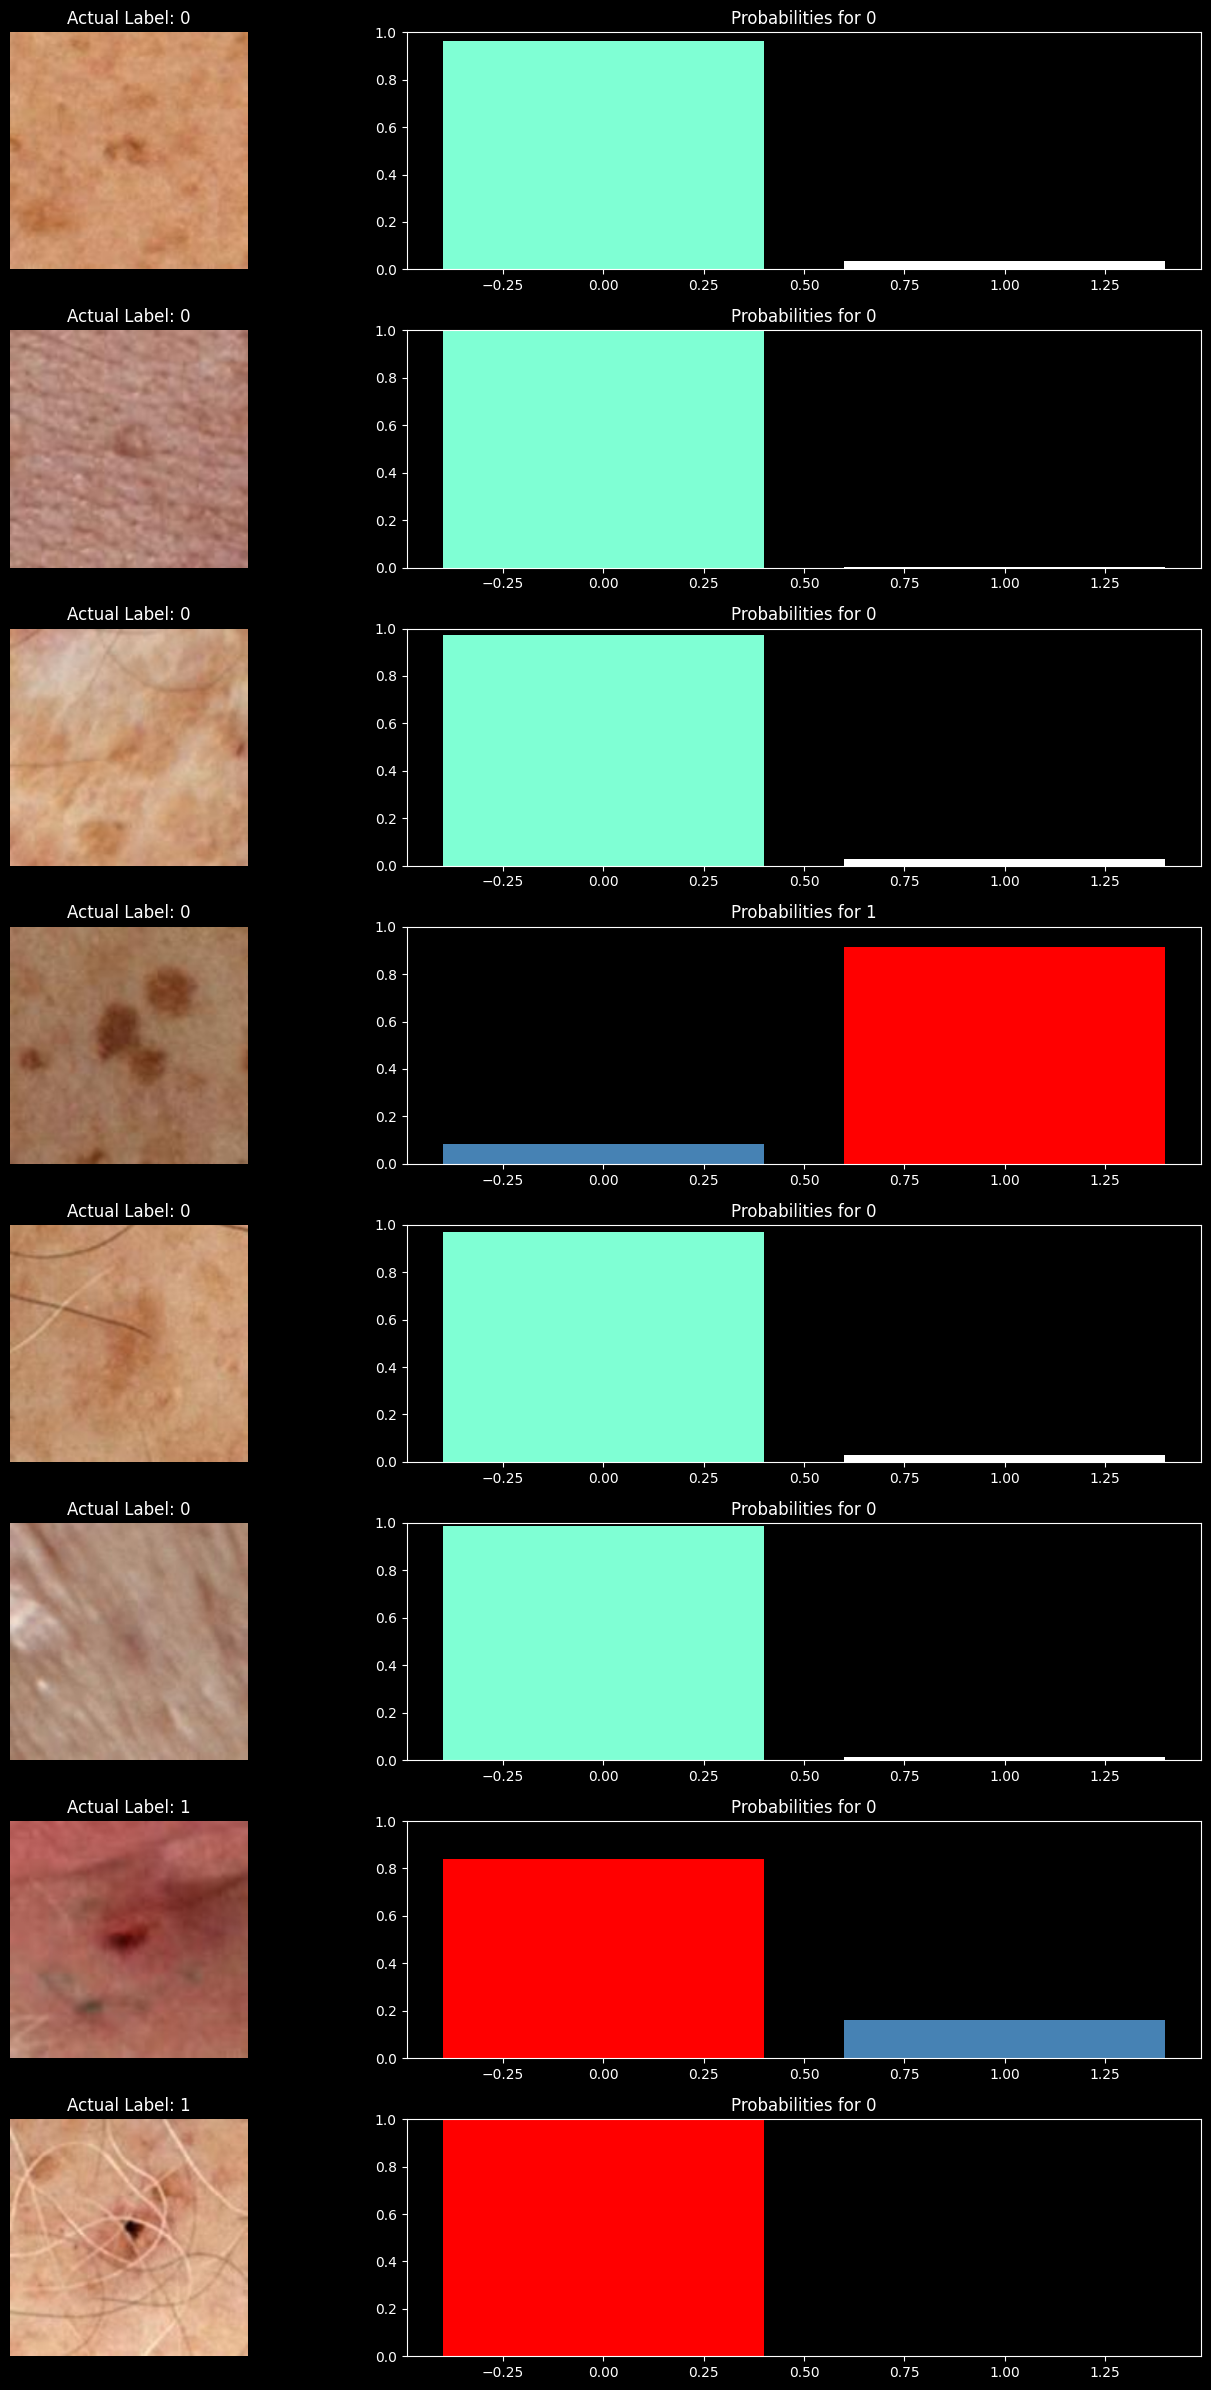

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import random

# Load your VGG model
VGG = models.vgg16(pretrained=True)

# Freeze the layers
for param in VGG.parameters():
    param.requires_grad = False

# Replace the final fully connected layer in the classifier
features = VGG.classifier[6].in_features
VGG.classifier[6] = nn.Linear(features, 2)

# Set the device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Model = VGG.to(device)

# Define optimizer and loss function
optimizer = optim.SGD(Model.parameters(), lr=0.003, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Assume 'train_dl' is your training DataLoader
# Get the dataset from the DataLoader
train_dataset = train_dl.dataset

# Randomly select 10 images
indices = random.sample(range(len(train_dataset)), 10)
train_subset = torch.utils.data.Subset(train_dataset, indices)

# Create a new DataLoader with the subset
train_dl_reduced = torch.utils.data.DataLoader(train_subset, batch_size=2, shuffle=True)

# Train the model using the reduced dataset
train(Model, optimizer, criterion, train_dl_reduced, valid_dl, 20)

# Plot the training/validation loss or accuracy
plot()

# Make predictions with the trained model
preds(Model)


# white box

In [19]:
import torch
import torch.nn as nn

def test_layer_shapes(model):
    """
    Test the shapes of the outputs at different layers.
    """
    # Define a dummy input
    dummy_input = torch.randn(1, 3, 299, 299)  # Batch size of 1, 3 channels, 299x299 image
    
    def hook_fn(module, input, output):
        print(f"Layer: {module.__class__.__name__}, Output Shape: {output.shape}")

    hooks = []
    for name, module in model.named_modules():
        hook = module.register_forward_hook(hook_fn)
        hooks.append(hook)

    # Perform a forward pass
    model(dummy_input)

    # Remove hooks
    for hook in hooks:
        hook.remove()

test_layer_shapes(Resnet50)

Layer: Conv2d, Output Shape: torch.Size([1, 64, 150, 150])
Layer: BatchNorm2d, Output Shape: torch.Size([1, 64, 150, 150])
Layer: ReLU, Output Shape: torch.Size([1, 64, 150, 150])
Layer: MaxPool2d, Output Shape: torch.Size([1, 64, 75, 75])
Layer: Conv2d, Output Shape: torch.Size([1, 64, 75, 75])
Layer: BatchNorm2d, Output Shape: torch.Size([1, 64, 75, 75])
Layer: ReLU, Output Shape: torch.Size([1, 64, 75, 75])
Layer: Conv2d, Output Shape: torch.Size([1, 64, 75, 75])
Layer: BatchNorm2d, Output Shape: torch.Size([1, 64, 75, 75])
Layer: ReLU, Output Shape: torch.Size([1, 64, 75, 75])
Layer: Conv2d, Output Shape: torch.Size([1, 256, 75, 75])
Layer: BatchNorm2d, Output Shape: torch.Size([1, 256, 75, 75])
Layer: Conv2d, Output Shape: torch.Size([1, 256, 75, 75])
Layer: BatchNorm2d, Output Shape: torch.Size([1, 256, 75, 75])
Layer: Sequential, Output Shape: torch.Size([1, 256, 75, 75])
Layer: ReLU, Output Shape: torch.Size([1, 256, 75, 75])
Layer: Bottleneck, Output Shape: torch.Size([1, 256,

# black box 

In [20]:
def black_box_test(model, test_loader, criterion):
    """
    Perform black box testing by evaluating the model on the test set.
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Loss: {total_loss / len(test_loader):.4f}, Test Accuracy: {accuracy:.2f}%")

black_box_test(Resnet50, test_dl, nn.CrossEntropyLoss())


Test Loss: 0.6226, Test Accuracy: 62.50%


# Gray box

In [21]:
def gray_box_test(model, test_loader, criterion):
    """
    Perform gray box testing combining both internal checks and functional evaluation.
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    def hook_fn(module, input, output):
        if isinstance(module, nn.Linear):  # Check linear layers specifically
            print(f"Linear Layer Output Shape: {output.shape}")

    hooks = [module.register_forward_hook(hook_fn) for name, module in model.named_modules()]
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Loss: {total_loss / len(test_loader):.4f}, Test Accuracy: {accuracy:.2f}%")
    
    for hook in hooks:
        hook.remove()

gray_box_test(Resnet50, test_dl, nn.CrossEntropyLoss())


Linear Layer Output Shape: torch.Size([8, 2])
Test Loss: 0.6226, Test Accuracy: 62.50%


# Integration Testing

In [23]:
def integration_test(model, train_dl, valid_dl):
    """
    Integration test to ensure end-to-end pipeline works.
    """
    optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    
    # Train the model
    train(model, optimizer, criterion, train_dl, valid_dl, epochs=1)
    
    # Validate the model
    black_box_test(model, valid_dl, criterion)

integration_test(Resnet50, train_dl, valid_dl)


Training the Epoch: 1
Epoch: [1/1], Loss: 0.0208, Train Acc: 73.63, Val Acc: 72.61
Test Loss: 0.6086, Test Accuracy: 72.61%


# system testing

In [24]:
def system_test(model, train_dl, valid_dl, test_dl):
    """
    System test to evaluate end-to-end functionality.
    """
    optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    
    # Train the model
    train(model, optimizer, criterion, train_dl, valid_dl, epochs=5)
    
    # Validate the model
    black_box_test(model, valid_dl, criterion)
    
    # Test the model
    black_box_test(model, test_dl, criterion)

system_test(Resnet50, train_dl, valid_dl, test_dl)

Training the Epoch: 1
Epoch: [1/5], Loss: 0.0170, Train Acc: 76.69, Val Acc: 71.97
Training the Epoch: 2
Epoch: [2/5], Loss: 0.0142, Train Acc: 78.96, Val Acc: 75.16
Training the Epoch: 3
Epoch: [3/5], Loss: 0.0146, Train Acc: 79.39, Val Acc: 77.71
Training the Epoch: 4
Epoch: [4/5], Loss: 0.0139, Train Acc: 79.96, Val Acc: 73.89
Training the Epoch: 5
Epoch: [5/5], Loss: 0.0130, Train Acc: 83.44, Val Acc: 73.25
Test Loss: 0.5913, Test Accuracy: 73.25%
Test Loss: 0.3102, Test Accuracy: 87.50%


Load Testing

In [25]:
def load_test(model, test_loader):
    """
    Perform load testing by evaluating the model's performance under a heavy load.
    """
    import time
    start_time = time.time()
    black_box_test(model, test_loader, nn.CrossEntropyLoss())
    end_time = time.time()
    print(f"Load Testing Duration: {end_time - start_time:.2f} seconds")

load_test(Resnet50, test_dl)


Test Loss: 0.3102, Test Accuracy: 87.50%
Load Testing Duration: 2.05 seconds


Stress Testing

In [26]:
def stress_test(model, test_loader):
    """
    Perform stress testing by evaluating the model with unusually large input data.
    """
    # Simulate stress by increasing batch size or input size
    stress_loader = DataLoader(test_ds, batch_size=128, shuffle=False)
    black_box_test(model, stress_loader, nn.CrossEntropyLoss())

stress_test(Resnet50, test_dl)


Test Loss: 0.3102, Test Accuracy: 87.50%


Scalability Testing

In [27]:
def scalability_test(model, test_loader):
    """
    Perform scalability testing by evaluating the model with increasing data sizes.
    """
    # Increasing the data size (if feasible)
    for batch_size in [32, 64, 128]:
        loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
        print(f"Testing with batch size: {batch_size}")
        black_box_test(model, loader, nn.CrossEntropyLoss())

scalability_test(Resnet50, test_dl)


Testing with batch size: 32
Test Loss: 0.3102, Test Accuracy: 87.50%
Testing with batch size: 64
Test Loss: 0.3102, Test Accuracy: 87.50%
Testing with batch size: 128
Test Loss: 0.3102, Test Accuracy: 87.50%


Usability Testing

In [30]:
def usability_test(model, test_loader):
    """
    Perform usability testing by evaluating the model and checking if outputs are practical.
    """
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            print(f"Probabilities: {probabilities.mean(dim=0)}")  # Check if outputs are reasonable
            break  # Just testing a sample

usability_test(Resnet50, test_dl)


Probabilities: tensor([0.6897, 0.3103])


Compatibility Testing

In [31]:
def compatibility_test(model, test_loader):
    """
    Perform compatibility testing by running the model on different devices (CPU/GPU).
    """
    devices = ['cuda:0' if torch.cuda.is_available() else 'cpu', 'cpu']
    for device in devices:
        print(f"Testing on device: {device}")
        model = Resnet50.to(device)
        black_box_test(model, test_loader, nn.CrossEntropyLoss())

compatibility_test(Resnet50, test_dl)


Testing on device: cpu
Test Loss: 0.3102, Test Accuracy: 87.50%
Testing on device: cpu
Test Loss: 0.3102, Test Accuracy: 87.50%


# Smoke testing

In [32]:
def smoke_test(model, test_loader):
    """
    Perform smoke testing to verify basic functionality.
    """
    model.eval()
    try:
        black_box_test(model, test_loader, nn.CrossEntropyLoss())
        print("Smoke Test Passed")
    except Exception as e:
        print(f"Smoke Test Failed: {e}")

smoke_test(Resnet50, test_dl)

Test Loss: 0.3102, Test Accuracy: 87.50%
Smoke Test Passed


# sanity Testing

In [33]:
def sanity_test(model, test_loader):
    """
    Perform sanity testing to verify the functionality of a specific feature.
    """
    model.eval()
    # Assuming bug fix related to output shapes
    try:
        black_box_test(model, test_loader, nn.CrossEntropyLoss())
        print("Sanity Test Passed")
    except Exception as e:
        print(f"Sanity Test Failed: {e}")

sanity_test(Resnet50, test_dl)


Test Loss: 0.3102, Test Accuracy: 87.50%
Sanity Test Passed


Regression Testing

In [34]:
def regression_test(model, test_loader):
    """
    Perform regression testing to ensure that recent changes did not break existing functionality.
    """
    model.eval()
    # Testing on a set of known results
    try:
        black_box_test(model, test_loader, nn.CrossEntropyLoss())
        print("Regression Test Passed")
    except Exception as e:
        print(f"Regression Test Failed: {e}")

regression_test(Resnet50, test_dl)


Test Loss: 0.3102, Test Accuracy: 87.50%
Regression Test Passed


Asseptence Testing

In [35]:
def acceptance_test(model, test_loader):
    """
    Perform acceptance testing to ensure the model meets the defined requirements.
    """
    model.eval()
    # Check if model meets predefined criteria
    try:
        black_box_test(model, test_loader, nn.CrossEntropyLoss())
        print("Acceptance Test Passed")
    except Exception as e:
        print(f"Acceptance Test Failed: {e}")

acceptance_test(Resnet50, test_dl)


Test Loss: 0.3102, Test Accuracy: 87.50%
Acceptance Test Passed


User asseptance Testing

In [36]:
def user_acceptance_test(model, test_loader):
    """
    Perform user acceptance testing by getting feedback from actual users.
    """
    model.eval()
    # Simulating user interaction
    try:
        for images, labels in test_loader:
            outputs = model(images)
            print(f"User Acceptance Test - Predicted: {torch.argmax(outputs, dim=1)}")
            break  # Testing with a sample
        print("User Acceptance Test Passed")
    except Exception as e:
        print(f"User Acceptance Test Failed: {e}")

user_acceptance_test(Resnet50, test_dl)


User Acceptance Test - Predicted: tensor([0, 0, 0, 1, 0, 0, 0, 0])
User Acceptance Test Passed
